<a href="https://colab.research.google.com/github/RayaneZen05/Fairness-in-AI/blob/main/TD1_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 1: Fairness notion examples

In this first TD we are going to manipulate some data and see the behaviour of the different fairness metrics

## Installation of the environnement

We highly recommend you to follow these steps, it will allow every student to work in an environment as similar as possible to the one used during testing.

### Colab Settings
  The next cell of code are to execute only once per colab environment


#### Python env creation

        ```
        ! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```
### Local Settings

#### 1. Uv installation


        https://docs.astral.sh/uv/getting-started/installation/


        `curl -LsSf https://astral.sh/uv/install.sh | sh`

        Python version 3.12 installation (highly recommended)
        `uv python install 3.12`


#### 3. Python env creation

        ```
        mkdir TD_bias_mitigation
        cd TD_bias_mitigation
        uv python pin 3.12
        uv init
        uv pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```


In [1]:
    ! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


## Objectives


 1. Study the data, the distribution of each feature and its relation to the target.

 2. Highlight some bias present in the data

 3. Learn a basic machine learning model using logistic regression

 4. Compute the confusion matrix and different fairness metrics

## Dataset: Diabetes 130-Hospitals


https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_diabetes_hospital.html

Ce dataset contient 101,766 lignes chacunes concernant un patient hospitalisé pour du diabètes sur une durée allant de 1 à 14 jours. Les données ont été récoltées sur 10 ans et 130 hopitaux différents. Chaque donnée possède 25 caractéristiques concernant des informations médicales, mais aussi demographiques, enfin la colonne 'readmitted' indique si le patient a été réadmis, et si oui s'il l'a été dans les 30jours ou après. Cette colonne est binarisée en deux autres 'readmit_30_days' (True si réadmis dans les 30 jours, False sinon) et 'readmitted' ( True si réadmis, False sinon).

Nous utiliserons en label/vérité, la colonne 'readmit_30_days'.

Nous allons simplifier en ne considérant qu'un sous-ensemble de 14 des caractéristiques fournies:
age, gender, race, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_diagnoses, max_glu_serum, A1Cresult, insulin, had_emergency, had_inpatient_days, had_outpatient_days





In [ ]:
# To execute only in Colab
! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit

In [2]:
# Code to compute fairness metrics using aif360

from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score


# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Download and simplify the dataset

In [3]:
import numpy as np
import fairlearn
np.__version__, fairlearn.__version__

('2.0.2', '0.13.0')

In [4]:
from fairlearn.datasets import fetch_diabetes_hospital
dataset = fetch_diabetes_hospital()

In [40]:
selection = [
    "age",
    "gender",
    "race",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_diagnoses",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "had_emergency",
    "had_inpatient_days",
    "had_outpatient_days"]
df = dataset.data[selection].copy(deep=True)
label = 'readmit_30_days'
df[label] = dataset.target
# We transform boolean into integer, False=>0, True=>1
df.had_emergency = df.had_emergency.replace({"True":1, "False":0})
df.had_inpatient_days = df.had_inpatient_days.replace({"True":1, "False":0})
df.had_outpatient_days = df.had_outpatient_days.replace({"True":1, "False":0})
df

/tmp/ipython-input-3640427316.py:20: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-3640427316.py:20: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/tmp/ipython-input-3640427316.py:21: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-3640427316.py:21: FutureWarning:

The behavior of Ser

,age,gender,race,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,insulin,had_emergency,had_inpatient_days,had_outpatient_days,readmit_30_days
0,'30 years or younger',Female,Caucasian,1,41,0,1,1,None,None,No,0,0,0,0
1,'30 years or younger',Female,Caucasian,3,59,0,18,9,None,None,Up,0,0,0,0
2,'30 years or younger',Female,AfricanAmerican,2,11,5,13,6,None,None,No,0,1,1,0
3,'30-60 years',Male,Caucasian,2,44,1,16,7,None,None,Up,0,0,0,0
4,'30-60 years',Male,Caucasian,1,51,0,8,5,None,None,Steady,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,'Over 60 years',Male,AfricanAmerican,3,51,0,16,9,None,>8,Down,0,0,0,0
101762,'Over 60 years',Female,AfricanAmerican,5,33,3,18,9,None,None,Steady,0,1,0,0
101763,'Over 60 years',Male,Caucasian,1,53,0,9,13,None,None,Down,0,0,1,0
101764,'Over 60 years',Female,Caucasian,10,45,2,21,9,None,None,Up,0,1,0,0


## Part 1: Data Analysis

### Question1 : Count the number of positive and negative label

In [14]:
df["readmit_30_days"].value_counts()

,count
readmit_30_days,
0,90409
1,11357


Now we look at the different features.
First the numerical features

### Question2: Display the distribution of the numerical features and compute their correlation with the target

In [15]:
def Compute_correlation(cola, colb):
  return np.corrcoef(df[cola].values, df[colb].values)[0][1]

In [29]:
for label in df.select_dtypes(include='number').columns[:-1]:
  corr = Compute_correlation(label, "readmit_30_days")
  print(f"Correlation de {label} avec readmit_30_days : {corr}")

Correlation de time_in_hospital avec readmit_30_days : 0.04419941845744675
Correlation de num_lab_procedures avec readmit_30_days : 0.0203636025675424
Correlation de num_procedures avec readmit_30_days : -0.01222693425174525
Correlation de num_medications avec readmit_30_days : 0.03843182216599565
Correlation de number_diagnoses avec readmit_30_days : 0.049524211905681015


Then we consider the categorical features.

### Question3: Display histogram of categorical distribution by label for each categorical features.

In [30]:
import plotly.express as px

def Display_categorical_hist(cat_feature, target):
  fig = px.histogram(df, x=cat_feature, color=target)
  fig.show()

def Display_categorical_hist_percent(cat_feature, target):
  df_summarized = df.groupby([target,cat_feature]).agg("count").reset_index()
  df_summarized[f"percent of {cat_feature}"] = df_summarized[[cat_feature,"time_in_hospital"]].apply(
    lambda x: 100*x[1]/df_summarized[df_summarized[cat_feature]==x[0]]["time_in_hospital"].sum(), axis=1
  )
  df_summarized[label] = df_summarized[label].astype(str)
  fig = px.bar(df_summarized, x=f"{cat_feature}", y=f"percent of {cat_feature}", color=target)
  fig.show()

In [41]:
for label in df.select_dtypes(exclude='number').columns[:-1]:
  Display_categorical_hist_percent(label, "readmit_30_days")

/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/tmp/ipython-input-2919813578.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2919813578.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



### Question4: What are the bias highlighted by the data analysis ?


L'analyse des correlations montre que les variables numériques sont faiblement corrélées linéairement à la réadmission.
De même l'analyse des variables catégorielles ne montrent pas de différences signicatives en réadmission pour chacune de leur valeur.
Il n'y a pas de bias mis en valeur ici.

## Part 2: Learn a Decision Tree and study the fairness of its output

### Question5: Utiliser la technique du "one hot encoding" pour transformer chaque colonne categorielle à N catégories en N colonnes binaires

In [42]:
for label in df.select_dtypes(exclude='number').columns[:-1]:
  onehot = pd.get_dummies(df[label])
  df = pd.concat([df, onehot], axis=1)
  df = df.drop(columns=[label])
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,had_outpatient_days,readmit_30_days,'30 years or younger','30-60 years','Over 60 years',...,None,Norm,Down,No,Steady,Up,0,1,0,1
0,1,41,0,1,1,0,0,True,False,False,...,True,False,False,True,False,False,True,False,True,False
1,3,59,0,18,9,0,0,True,False,False,...,True,False,False,False,False,True,True,False,True,False
2,2,11,5,13,6,1,0,True,False,False,...,True,False,False,True,False,False,True,False,False,True
3,2,44,1,16,7,0,0,False,True,False,...,True,False,False,False,False,True,True,False,True,False
4,1,51,0,8,5,0,0,False,True,False,...,True,False,False,False,True,False,True,False,True,False


### Question6 : Split data into train and test sets



In [51]:
import sklearn
df.columns = df.columns.astype(str)
X = df.drop(columns=["readmit_30_days"])
y = df["readmit_30_days"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### Question 7: Train a DecisionTreeClassifier (https://scikit-learn.org/stable/modules/tree.html#classification)

In [52]:
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

### Question8: Compute the Confusion Matrix

In [53]:
y_pred = clf.predict(X_test)
sklearn.metrics.confusion_matrix(y_test, y_pred)

# Create the 'gender' column as requested: 1 for Female, 0 for Male
# Assumes 'Female' and 'Male' columns exist in X_test due to one-hot encoding
X_test['gender'] = X_test['Female'].astype(int)

array([[15646,  2423],
       [ 1919,   366]])

In [60]:
y_test.shape, y_pred.shape

((20354,), (20354,))

### Question 9: Compute base rate metrics for a sensitive binary attribute (gender, race etc)

In [69]:
# réinsertion de la colonne genre
X_test["gender"] = X_test["Female"].astype(int)

In [70]:
get_metrics(y_test,y_pred,prot_attr=X_test["gender"])

{'base_rate_truth': np.float64(0.11226294585830796),
 'statistical_parity_difference': np.float64(-0.006942498433736621),
 'disparate_impact_ratio': 0.9504906873724166,
 'base_rate_preds': np.float64(0.13702466345681438),
 'equal_opportunity_difference': -0.0016623337279862704,
 'average_odds_difference': -0.004584023328243356,
 'conditional_demographic_disparity': np.float64(-0.0011339236743134946),
 'smoothed_edf': np.float64(0.050717724815925624),
 'df_bias_amplification': np.float64(0.019571265491095335),
 'balanced_accuracy_score': np.float64(0.5130389911853819)}

### Question 10: Compute model perfomance for a sensitive binary attribute (gender, race etc)

In [74]:
mask_femme = (X_test['gender'] == 0)
acc_femme = sklearn.metrics.mean_squared_error(y_test[mask_femme], y_pred[mask_femme])

mask_homme = (X_test['gender'] == 1)
acc_homme = sklearn.metrics.mean_squared_error(y_test[mask_homme], y_pred[mask_homme])

print(f"Accuracy Femmes: {acc_femme}")
print(f"Accuracy Hommes: {acc_homme}")
print(f"Différence: {acc_homme - acc_femme}")

Accuracy Femmes: 0.20850202429149797
Accuracy Hommes: 0.2174507658643326
Différence: 0.008948741572834623


### Question 11: Compute model calibration according to a sensitive binary attribute (gender, race etc)

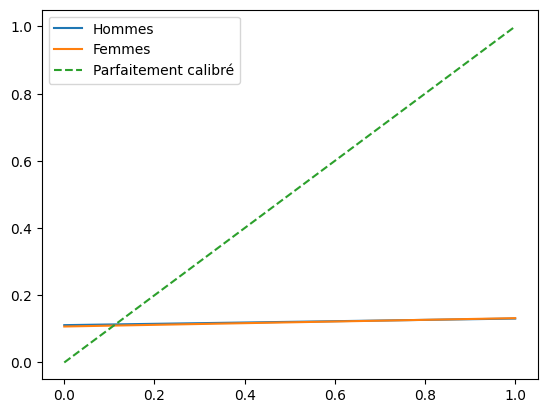

In [76]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_test_H = y_test[mask_homme]
y_test_F = y_test[mask_femme]
y_prob_H = y_pred[mask_homme]
y_prob_F = y_pred[mask_femme]

prob_true_H, prob_pred_H = calibration_curve(y_test_H, y_prob_H, n_bins=10)
prob_true_F, prob_pred_F = calibration_curve(y_test_F, y_prob_F, n_bins=10)

plt.plot(prob_pred_H, prob_true_H, label='Hommes')
plt.plot(prob_pred_F, prob_true_F, label='Femmes')
plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
plt.legend()
plt.show()